In [1]:
import torch
from torch import nn
import os
import math
import json
import platform
from transformers import AutoTokenizer

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
if platform.system() == 'Darwin':
    torch.set_default_device('mps')
else:
    torch.set_default_device('cuda')


/Users/siancao/work/llm/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Write GPT2 by hand

links: 
- [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf)
- [GPT2](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
- [Layer Norm](https://nn.labml.ai/normalization/layer_norm/index.html)

Self-attention:

$ \text{attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V $

safe softmax ([stable softmax](https://jaykmody.com/blog/stable-softmax/)):

$ \text{softmax}(X) = \frac{e^{x_i-x.max()}} {\sum_{j=0}^n e^{x_j-x.max()}} $


model details:

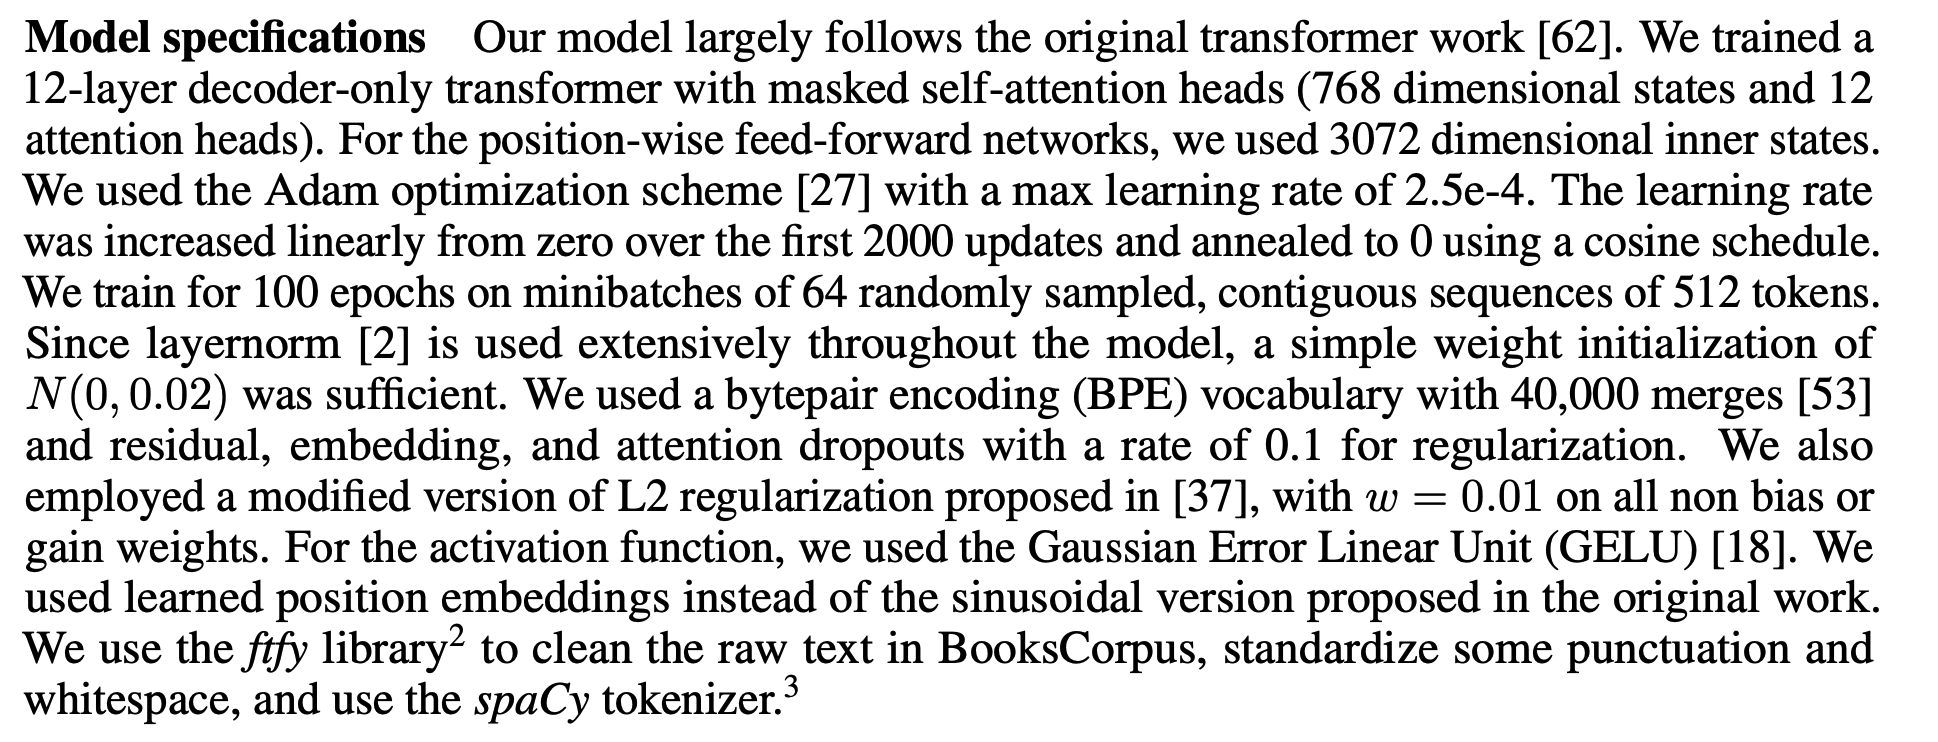


In [198]:
# model
from typing import List, Optional, Tuple
import torch.nn.functional as F
import einops


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config['n_embd'], config['n_embd'] * 4)
        self.c_proj = nn.Linear(config['n_embd'] * 4, config['n_embd'])
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.c_proj(self.gelu(self.c_fc(x)))
        return x


class LayerNorm(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.epsilon = config['layer_norm_epsilon']
        self.weight = nn.Parameter(torch.ones(config['n_embd']))
        self.bias = nn.Parameter(torch.zeros(config['n_embd']))

    def forward(self, x: torch.Tensor):
        # return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True)

        x = (x - mean) / torch.sqrt(var + self.epsilon) 
        x = self.weight * x + self.bias
        return x

# https://jaykmody.com/blog/stable-softmax/
def softmax(x: torch.Tensor):
    # return F.softmax(x, dim=-1)
    exp_x = torch.exp(x - torch.max(x, dim=-1, keepdim=True)[0])
    return exp_x / exp_x.sum(dim=-1, keepdim=True)

class MultiHeadAttention(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.config = config
        self.c_attn = nn.Linear(config['n_embd'], config['n_embd']*3)
        self.c_proj = nn.Linear(config['n_embd'], config['n_embd'])
        self.attn_pdrop = nn.Dropout(config['attn_pdrop'])
        self.resid_pdrop = nn.Dropout(config['resid_pdrop'])
        # this is '.attn.bias' in state_dict

        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        # self.flash = False
        sz = config['n_ctx']
        self.register_buffer('bias', torch.tril(torch.ones(sz, sz))[None, None, :, :]) # [1, 1, sz, sz]

    def attention(self, q, k, v, mask=None):
        kv_seqlen = k.shape[-2]
        q_seqlen = q.shape[-2]
        attn = einops.einsum(q, k, 'b h q d, b h k d -> b h q k') * (1.0 / math.sqrt(k.shape[-1]))
        attn = attn.masked_fill(self.bias[:, :, kv_seqlen-q_seqlen:kv_seqlen, :kv_seqlen] == 0, float('-inf'))
        attn = softmax(attn)
        attn = self.attn_pdrop(attn)
        return attn @ v

    def forward(self, x: torch.Tensor, past_key_values=None, use_cache=False):
        B, S, C = x.shape
        nh = self.config['n_head']

        # SDPA
        q, k, v = self.c_attn(x).split(C, dim=-1) #  (B, S, C)
        q = einops.rearrange(q, 'b s (h d) -> b h s d', h=nh)
        k = einops.rearrange(k, 'b s (h d) -> b h s d', h=nh)
        v = einops.rearrange(v, 'b s (h d) -> b h s d', h=nh)

        if past_key_values is not None:
            assert use_cache
            prev_k, prev_v = past_key_values
            assert k.size(-2) == 1
            k = torch.cat((prev_k, k), dim=-2)
            v = torch.cat((prev_v, v), dim=-2) 

        if use_cache:
            past_key_values = (k, v)

        if self.flash:
            ks = k.shape[-2]
            qs = q.shape[-2]
            attn_mask = self.bias[:, :, ks-qs:ks, :ks] == 1 # sdpa needs bool mask 
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=attn_mask, 
                    dropout_p=self.config['attn_pdrop'] if self.training else 0,
                    is_causal=False)
        else:
            y = self.attention(q, k, v) # B, nh, S, C//nh

        # y = y.transpose(1, 2).contiguous().view(B, S, C)
        y = einops.rearrange(y, 'b h s c -> b s (h c)')

        y = self.resid_pdrop(self.c_proj(y))
        if use_cache:
            return y, past_key_values
        return (y,)
        

class TransformerBlock(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.ln_1 = LayerNorm(config)
        self.attn = MultiHeadAttention(config)
        self.ln_2 = LayerNorm(config)
        self.mlp = MLP(config)

    def forward(self, x, past_key_values=None, use_cache=False):
        # pre-norm
        outputs = self.attn(self.ln_1(x), past_key_values=past_key_values, use_cache=use_cache)
        x = x + outputs[0]
        # post-norm
        x = x + self.mlp(self.ln_2(x))
        if use_cache:
            return x, outputs[1] # x, cache
        else:
            return (x,)

# from GPT2:
# Layer normalization (Ba et al., 2016) was moved to the input of each sub-block, similar to a
# pre-activation residual network (He et al., 2016) and an additional layer normalization was
# added after the final selfattention block. A modified initialization which accounts
# for the accumulation on the residual path with model depth
# is used. We scale the weights of residual layers at initialization by a factor of 
# 1/√N where N is the number of residual layers. The vocabulary is expanded to 50,257. We
# also increase the context size from 512 to 1024 tokens and a larger batchsize of 512 is used

class GPT2(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.wte = nn.Embedding(config['vocab_size'], config['n_embd'])
        self.wpe = nn.Embedding(config['n_positions'], config['n_embd'])
        self.embd_pdrop = nn.Dropout(config['embd_pdrop'])

        self.h = nn.ModuleList([TransformerBlock(config) for _ in range(config['n_layer'])])
        self.ln_f = LayerNorm(config)

        self.lm_head = nn.Linear(config['n_embd'], config['vocab_size'], bias=False)

        self.initializer_range = config['initializer_range']

        self.wte.weight = self.lm_head.weight

        self.apply(self._init_weights)
        # see comments above
        for nm, p in self.named_parameters():
            if nm.endswith('c_proj.weight'):
                std = self.initializer_range/math.sqrt(2 * config['n_layer'])
                torch.nn.init.normal_(p, mean=0.0, std=std)

    def forward(self, x, past_key_values: Optional[Tuple[Tuple[torch.Tensor]]]=None, use_cache=False):
        T = x.shape[1]
        assert T <= self.config['n_positions'], "Cannot forward, model block size is exhausted."

        past_length = 0
        if use_cache:
            if past_key_values[0] is not None:
                assert isinstance(past_key_values, tuple)  \
                    and isinstance(past_key_values[0], tuple) \
                    and len(past_key_values[0][0]) == 2
                past_length = past_key_values[0][0].shape[-2]
                T += past_length

        embd = self.wte(x) + self.wpe(torch.arange(past_length, T, dtype=torch.long).unsqueeze(0))
        hidden_states = self.embd_pdrop(embd)

        presents = ()
        for _, (decoder, kv_cache) in enumerate(zip(self.h, past_key_values)):
            outputs = decoder(hidden_states, past_key_values=kv_cache, use_cache=use_cache)
            hidden_states = outputs[0]
            if use_cache:
                presents = presents + (outputs[1],)

        hidden_states = self.ln_f(hidden_states)

        logits = self.lm_head(hidden_states)
        if use_cache:
            return (logits, presents)
        else:
            return (logits,)

    def _init_weights(self, module: nn.Module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.initializer_range)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.initializer_range)

    def from_pretrained(model_dir):
        with open(os.path.join(model_dir, 'config.json'), mode='r') as f:
            config = json.load(f)

        model = GPT2(config)
        model.eval()
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param
        sd_keys = [k for k in sd_keys if not k.endswith('lm_head.weight')] 

        weights = torch.load(os.path.join(model_dir, 'pytorch_model.bin'))
        # these weights need to be transposed , original GPT2 uses conv1d
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # skip .attn.bias which is mask
        keys = [k for k in weights.keys() if '.attn.bias' not in k]
        assert len(keys) == len(sd_keys), f"mismatched keys: {len(keys)} != {len(sd_keys)}"
        for k in keys:
            if any([k.endswith(n) for n in transposed]):
                assert sd[k].shape == weights[k].shape[::-1], f"shape mismatch : {k} {sd[k].shape} {weights[k].shape}"
                with torch.no_grad():
                    sd[k].copy_(weights[k].t())

            elif k in sd:
                assert sd[k].shape == weights[k].shape, f"shape mismatch : {k} {sd[k].shape} {weights[k].shape}"
                with torch.no_grad():
                    sd[k].copy_(weights[k])

        # sd['lm_head.weight'].copy_(weights['wte.weight'])

        return model

    def handle_repetition_penalty(self, input_ids: torch.Tensor, logits: torch.Tensor,
                                   repetition_penalty: float = 1.0) -> torch.Tensor:
        """
        If `repetition_penalty` is set to a non-zero `float`, then there are additional
        logic for calculating the probability of generating a repeated token.
        """

        candidates = torch.gather(logits, -1, input_ids)
        candidates = torch.where(candidates < 0, candidates * repetition_penalty,
                                  candidates / repetition_penalty)

        logits.scatter(-1, input_ids, candidates)
        return logits


    @torch.no_grad()
    def generate(self, input_ids, do_sample=False, temperature = 1.0, top_k=None,
                  top_p = 0.95, max_new_tokens=10, repetition_penalty=1.0, use_cache=False):

        past_key_values = tuple([None] * self.config['n_layer'])

        maxpos = self.config['n_positions']
        for _ in range(max_new_tokens):
            idx = input_ids if input_ids.size(1) <= maxpos else input_ids[:, -maxpos:]
            if past_key_values[0] is not None:
                idx = idx[:, -1:]

            outputs = self(idx, past_key_values=past_key_values, use_cache=use_cache) # (B, S, V)
            logits = outputs[0]
            if use_cache:
                past_key_values = outputs[1]

            logits = logits[:, -1, :] / temperature

            logits = self.handle_repetition_penalty(input_ids, logits, repetition_penalty)

            if do_sample and top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.shape[-1]))
                logits[logits < v[:, [-1]]] = float('-inf')

            probs = torch.nn.functional.softmax(logits, dim=-1) # (B, V)
            if do_sample:
                if top_p is not None:
                    sorted, indices = torch.sort(probs, dim=1, descending=True)

                    csum = torch.cumsum(sorted, dim=-1)
                    indices_to_remove = csum > top_p
                    indices_to_remove[:, 1:] = indices_to_remove[:, :-1].clone()
                    indices_to_remove[:, 0] = False

                    sorted[indices_to_remove] = 0
                    sorted /= sorted.sum(dim=-1, keepdim=True)

                    selected = torch.multinomial(sorted, num_samples=1).squeeze()
                    next_id = indices[torch.arange(indices.size(0)), selected].unsqueeze(1)

                else:
                    next_id = torch.multinomial(probs, num_samples=1)
            else:
                # greedy
                next_id = torch.argmax(probs, dim=-1, keepdim=True)
            input_ids = torch.cat([input_ids, next_id], dim=1)

        return input_ids

def predict(model, tokenizer, prompt: List[str], max_new_tokens=10, do_sample=False,
             top_p=None, top_k=None, repetition_penalty=1.0, use_cache=False):
    inputs = tokenizer(prompt, padding=True, return_tensors="pt")
    output = model.generate(inputs['input_ids'], do_sample=do_sample, top_k=top_k,
                            repetition_penalty=repetition_penalty, use_cache=use_cache,
                            top_p=top_p, max_new_tokens=max_new_tokens)
    response = tokenizer.batch_decode(output, skip_special_tokens=True)
    return response



In [199]:
prompts = [
    "Alan Turing theorized that computers would one day become",
    "Once upon a time, there ",
]

g = GPT2.from_pretrained('./gpt2')
tokenizer = AutoTokenizer.from_pretrained('./gpt2/')
tokenizer.pad_token_id = tokenizer.eos_token_id

print(predict(g, tokenizer, prompts, max_new_tokens=10, do_sample=False, use_cache=True))

['Alan Turing theorized that computers would one day become the most powerful machines on the planet.\n\n', 'Once upon a time, there The U.S. Department of Justice has filed']


In [196]:
print(predict(g, tokenizer, prompts, max_new_tokens=80, do_sample=False, use_cache=True))

['Alan Turing theorized that computers would one day become the most powerful machines on the planet.\n\nThe computer is a machine that can perform complex calculations, and it can perform these calculations in a way that is very similar to the human brain.\n\nThe computer is also capable of performing calculations that are very similar to the human brain.\n\nThe computer is also capable of performing calculations that are very similar to the human brain.\n\nThe', "Once upon a time, there The U.S. Department of Justice has filed a lawsuit against the company that owns the National Security Agency's (NSA) Tailored Access Operations (TAO) program, alleging that the program violates the Fourth Amendment.\n\nThe lawsuit, filed in U.S. District Court in Washington, D.C., alleges that the NSA's Tailored Access Operations (TAO) program violates the"]


In [197]:
print(predict(g, tokenizer, prompts, max_new_tokens=80, do_sample=False, use_cache=False))

['Alan Turing theorized that computers would one day become the most powerful machines on the planet.\n\nThe computer is a machine that can perform complex calculations, and it can perform these calculations in a way that is very similar to the human brain.\n\nThe computer is also capable of performing calculations that are very similar to the human brain.\n\nThe computer is also capable of performing calculations that are very similar to the human brain.\n\nThe', "Once upon a time, there The U.S. Department of Justice has filed a lawsuit against the company that owns the National Security Agency's (NSA) Tailored Access Operations (TAO) program, alleging that the program violates the Fourth Amendment.\n\nThe lawsuit, filed in U.S. District Court in Washington, D.C., alleges that the NSA's Tailored Access Operations (TAO) program violates the"]


In [105]:
print(predict(g, tokenizer, prompts, max_new_tokens=20, do_sample=True, top_p=0.9, top_k=200))
print(predict(g, tokenizer, prompts, max_new_tokens=20, do_sample=True, top_p=0.99, top_k=1))

['Alan Turing theorized that computers would one day become "the equivalent of an entire military," which he had imagined at the time. (An earlier version', 'Once upon a time, there Abstract\n\nThere is not a true sense of universal purpose within an object or a mathematical system.']
['Alan Turing theorized that computers would one day become the most powerful machines on the planet.\n\nThe computer is a machine that can perform complex calculations', 'Once upon a time, there The U.S. Department of Justice has filed a lawsuit against the company that owns the National Security']
